In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from properscoring import crps_gaussian

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI, number_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-24 15:26:18.543785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-24 15:26:19.122039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


In [3]:
def optimise_predict_model(model, epochs=50):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    for epoch in range(1, epochs + 1):
        optimisation_step()
    
    # fitted values
    mean_train, var_train = model.predict_y(x_train)
    print('Train')
    plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    # predict
    mean_test, var_test = model.predict_y(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))
    print('number out of CI (train, test): ', number_outof_CI(y_train, mean_train, var_train), number_outof_CI(y_test, mean_test, var_test))
    print('Avg. CRPS (train, test): ', np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train))), np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))))

    print_summary(model, fmt='notebook')
    

p, l1, l2, s1, s2:  77 77 0.5 1 1
--------------------------------------------------------
Train


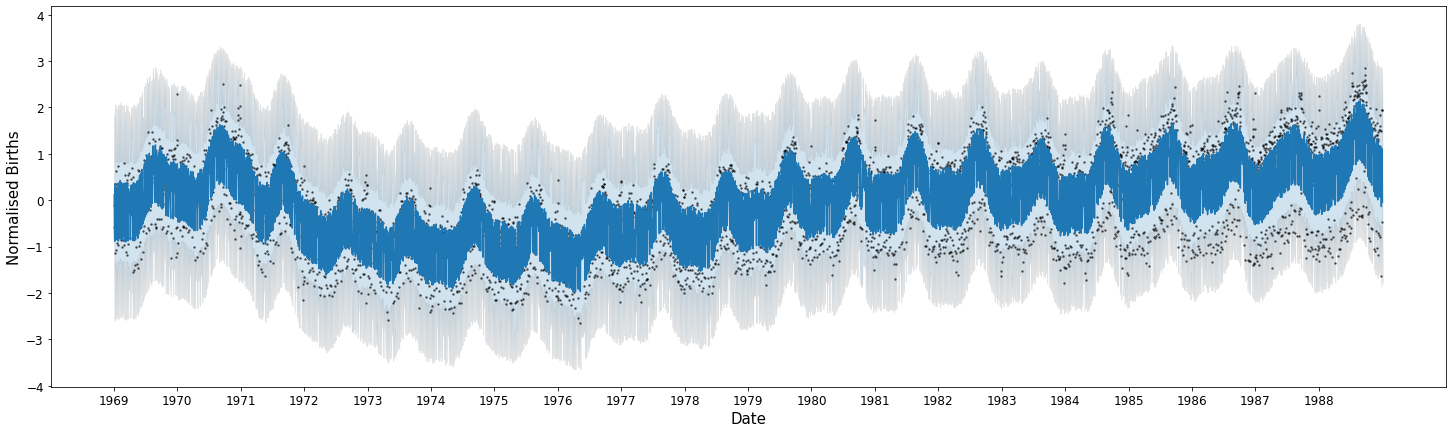

Test


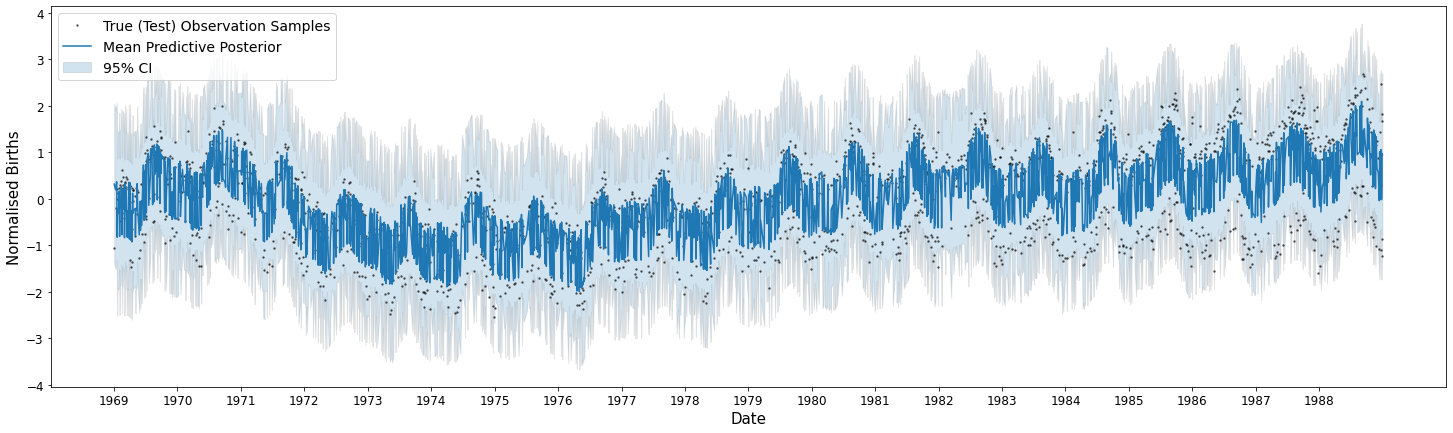

train ELBO, MSE, MAE:  -3056.694675753861 0.2185663960284287 0.3706373986116021
test ELBO, MSE, MAE:  -3124.481187674376 0.249183402359167 0.3924472026783341
percentage out of CI (train, test):  0.37160179933502835 0.5474452554744526
number out of CI (train, test):  19 12
Avg. CRPS (train, test):  0.2939293994153827 0.3054444496438011


--------------------------------------------------------
p, l1, l2, s1, s2:  77 77 1 1 1
--------------------------------------------------------
Train


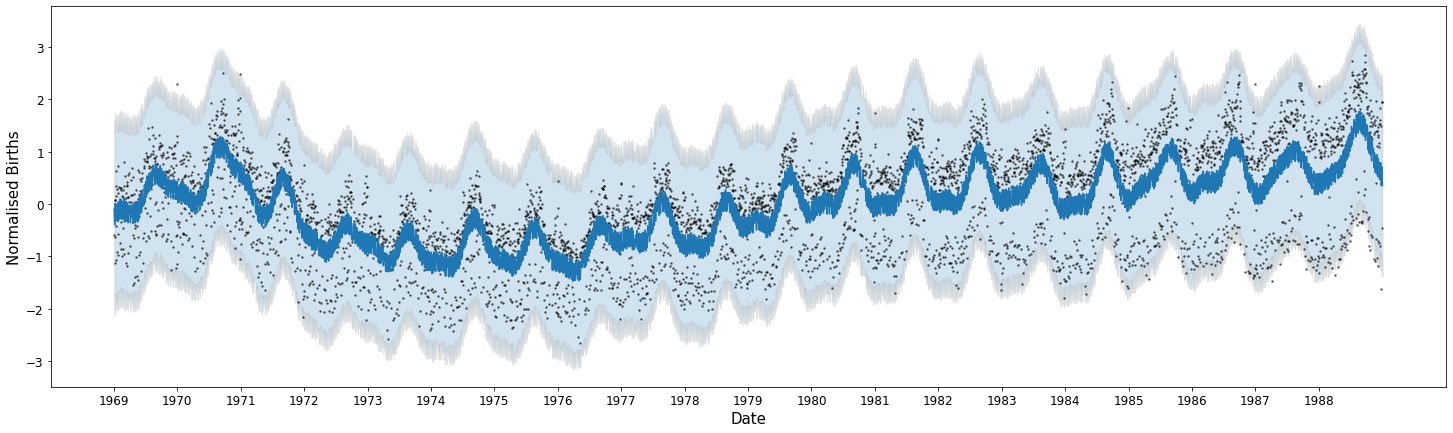

Test


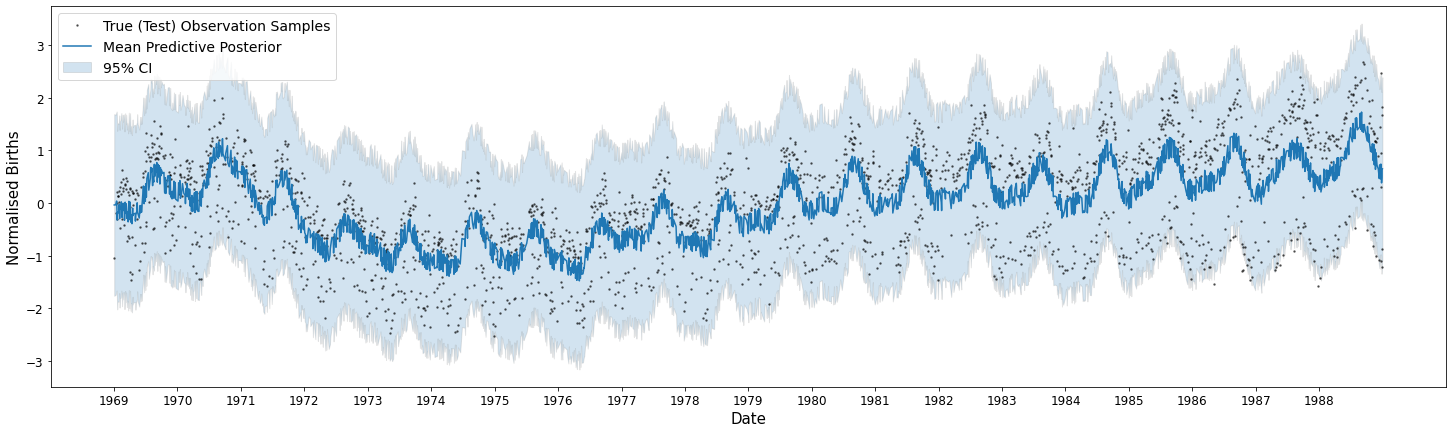

train ELBO, MSE, MAE:  -3429.439891555858 0.4206888727217053 0.5377348492411024
test ELBO, MSE, MAE:  -3500.2003223340603 0.4534624788645369 0.55651168728082
percentage out of CI (train, test):  0.6062976725992567 0.6843065693430658
number out of CI (train, test):  31 15
Avg. CRPS (train, test):  0.37652577150823247 0.3889617353020567


--------------------------------------------------------
p, l1, l2, s1, s2:  77 100 0.5 1 1
--------------------------------------------------------
Train


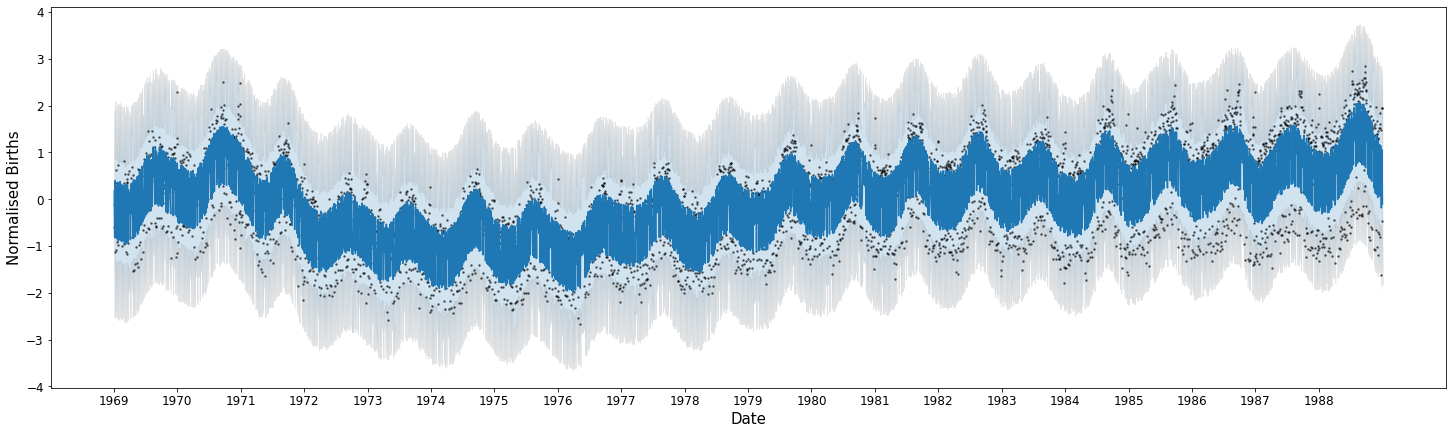

Test


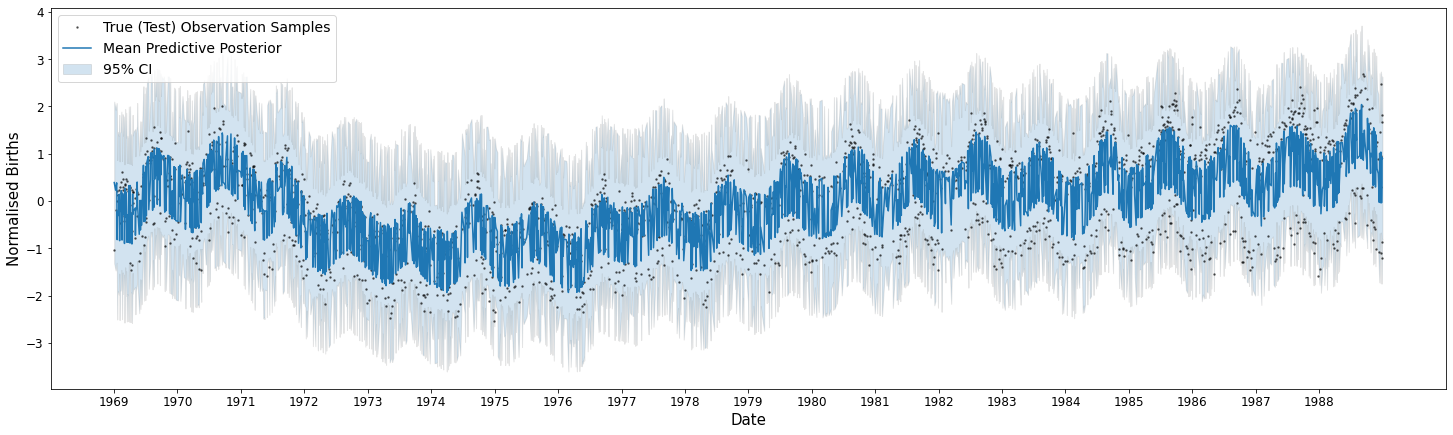

train ELBO, MSE, MAE:  -3058.3732246721565 0.23061133666342296 0.38105425493153106
test ELBO, MSE, MAE:  -3131.993915511896 0.2641735665629638 0.4050862050985672
percentage out of CI (train, test):  0.35204380989634265 0.7299270072992701
number out of CI (train, test):  18 16
Avg. CRPS (train, test):  0.2986107845024393 0.31114419165692286


--------------------------------------------------------
p, l1, l2, s1, s2:  77 100 1 1 1
--------------------------------------------------------
Train


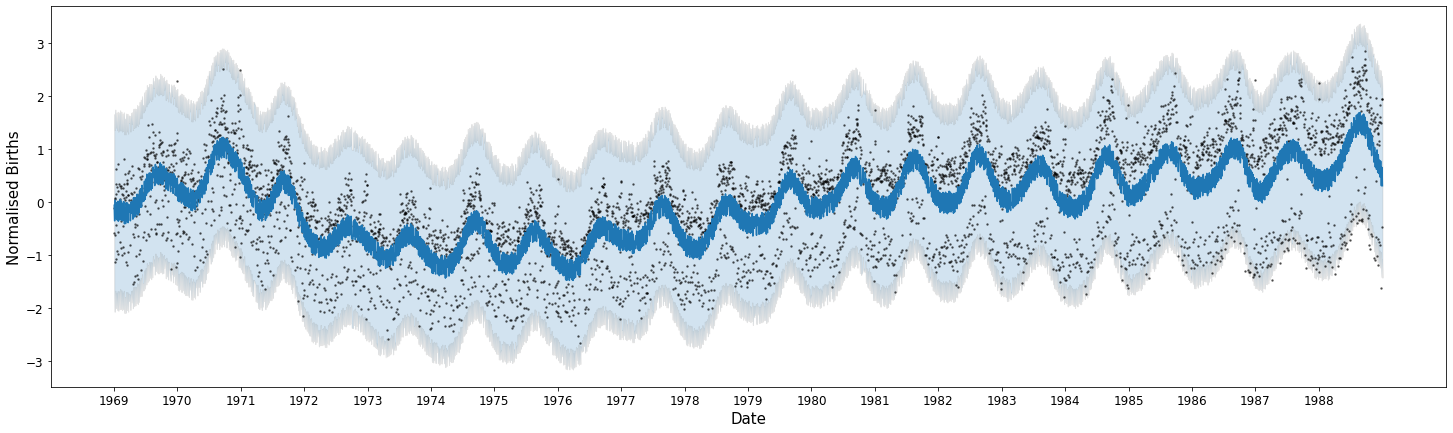

Test


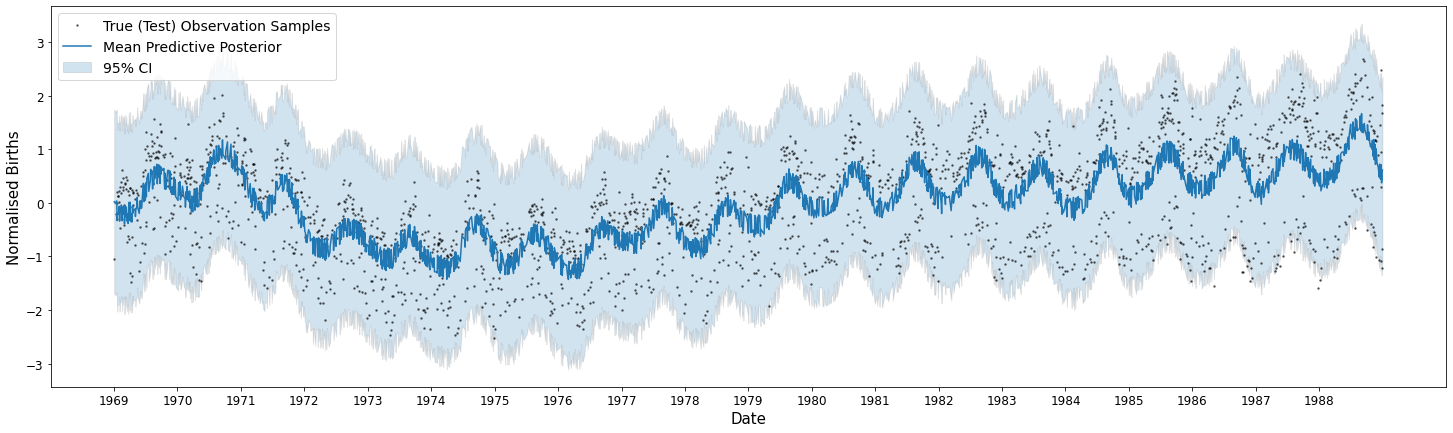

train ELBO, MSE, MAE:  -3431.2778937634994 0.43279393982245046 0.5435803492620332
test ELBO, MSE, MAE:  -3510.474839816098 0.4697995324082931 0.5653990934396699
percentage out of CI (train, test):  0.6258556620379425 0.7755474452554745
number out of CI (train, test):  32 17
Avg. CRPS (train, test):  0.38089056632935986 0.39498824776804115


--------------------------------------------------------
p, l1, l2, s1, s2:  77 150 0.5 1 1
--------------------------------------------------------
Train


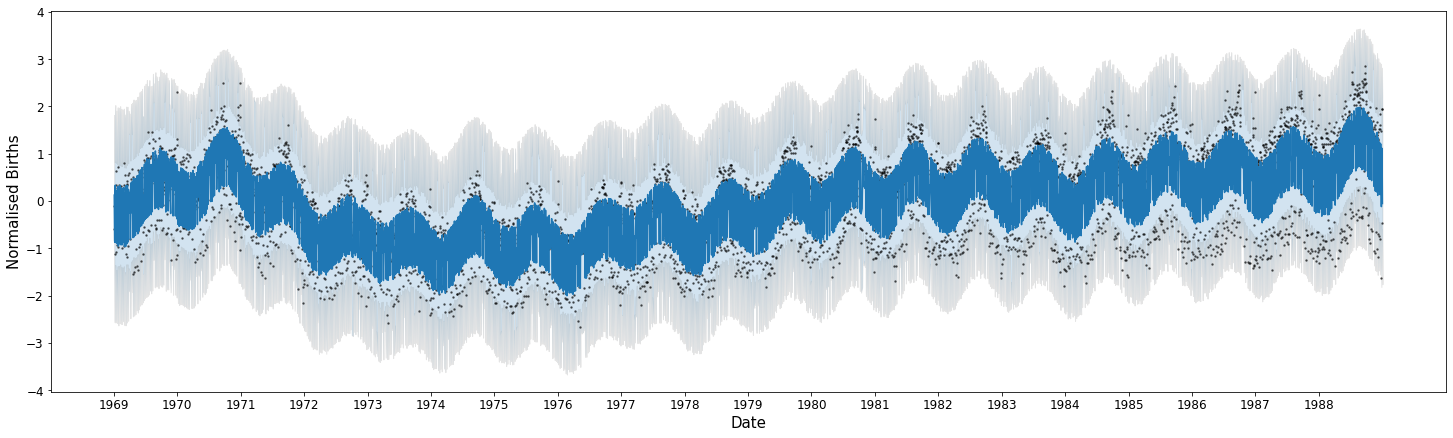

Test


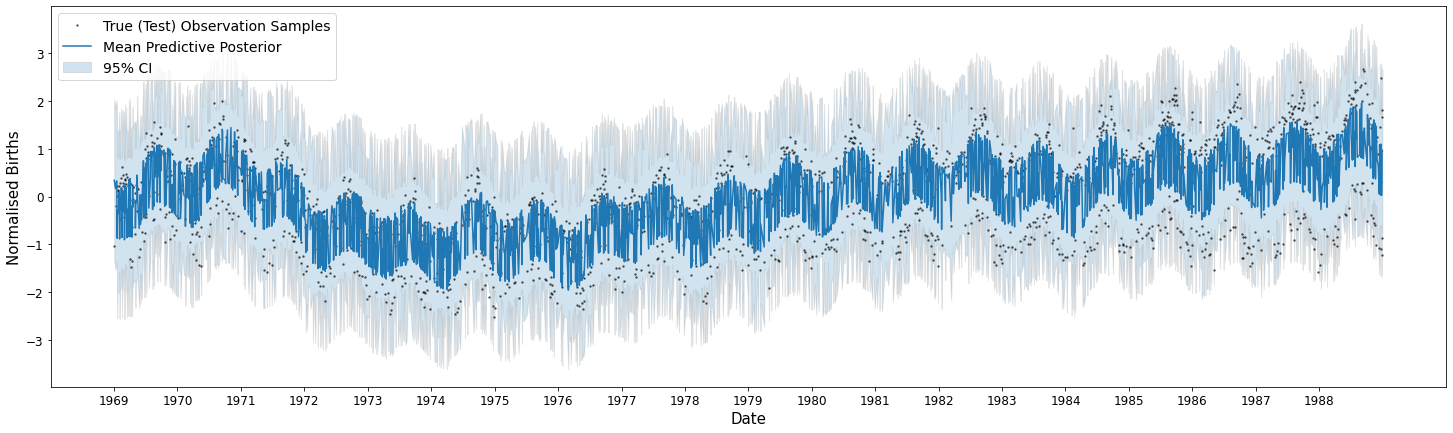

train ELBO, MSE, MAE:  -3057.2756440312614 0.24303793566500662 0.3909436190894211
test ELBO, MSE, MAE:  -3129.754229580408 0.27631233921443754 0.41471004506311365
percentage out of CI (train, test):  0.35204380989634265 0.7299270072992701
number out of CI (train, test):  18 16
Avg. CRPS (train, test):  0.30337261567300705 0.31566860400468605


--------------------------------------------------------
p, l1, l2, s1, s2:  77 150 1 1 1
--------------------------------------------------------
Train


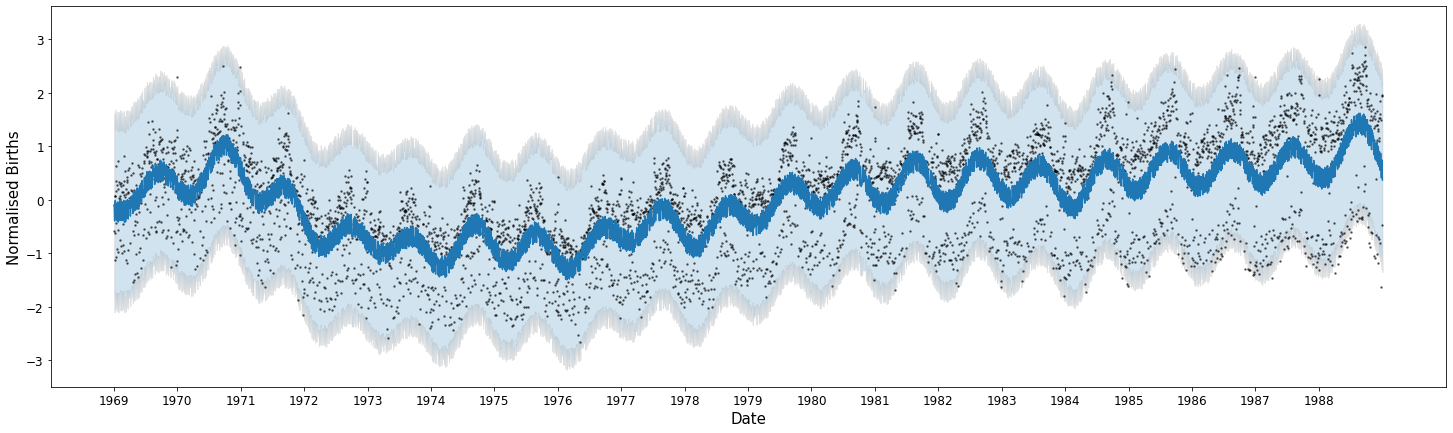

Test


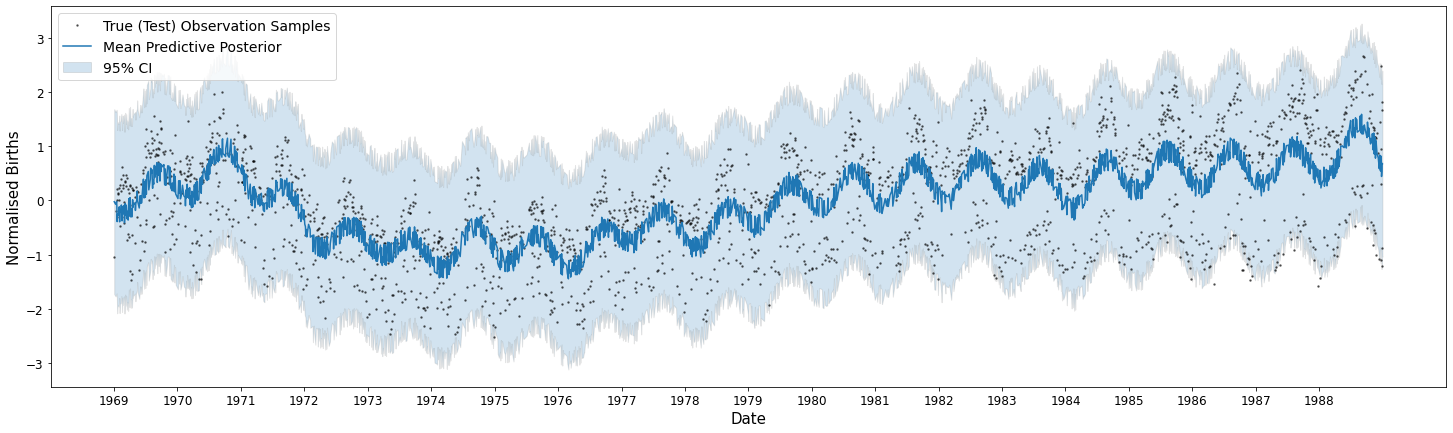

train ELBO, MSE, MAE:  -3427.9320074532334 0.44424306027286786 0.5479946816020672
test ELBO, MSE, MAE:  -3502.643799620302 0.4793492276073274 0.5686439369719289
percentage out of CI (train, test):  0.7040876197926853 0.7299270072992701
number out of CI (train, test):  36 16
Avg. CRPS (train, test):  0.38479287310619087 0.39825087393725167


--------------------------------------------------------
p, l1, l2, s1, s2:  77 200 0.5 1 1
--------------------------------------------------------
Train


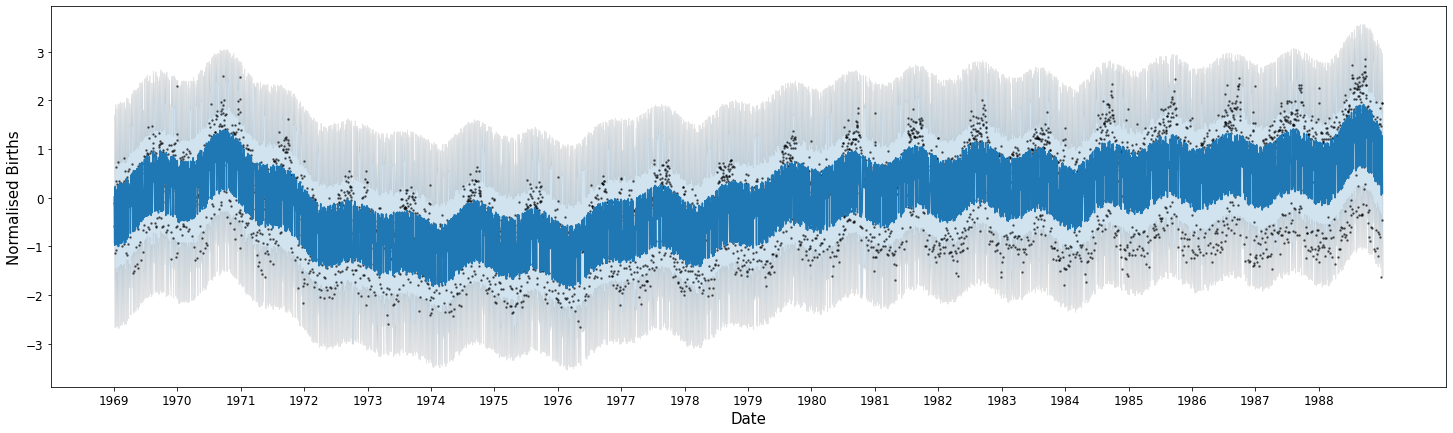

Test


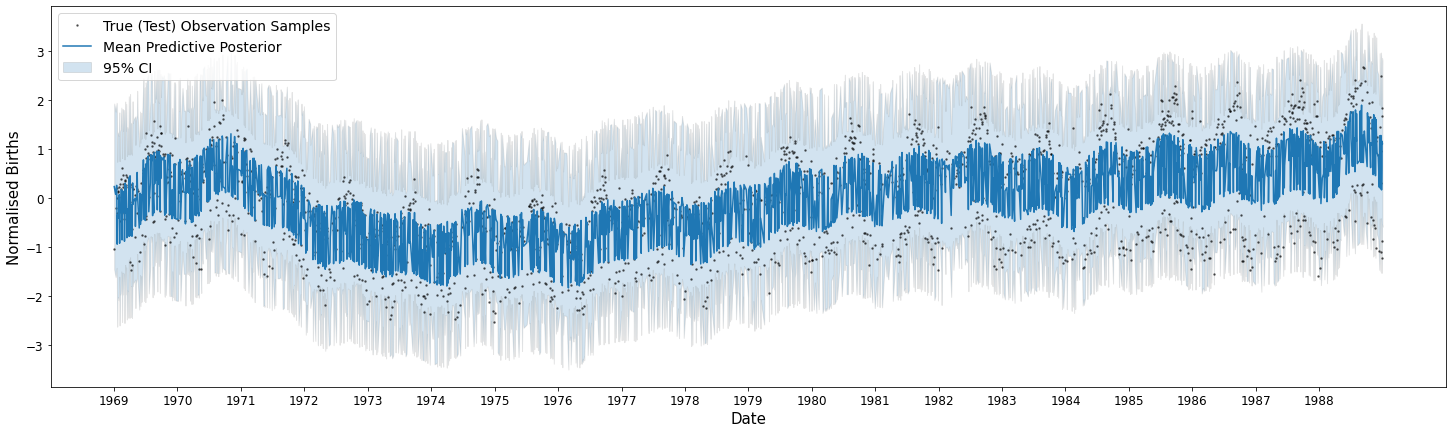

train ELBO, MSE, MAE:  -3100.956641982326 0.2639299978661906 0.40642552728610404
test ELBO, MSE, MAE:  -3174.421027276896 0.2977050577861456 0.43087277275114855
percentage out of CI (train, test):  0.37160179933502835 0.8211678832116789
number out of CI (train, test):  19 18
Avg. CRPS (train, test):  0.3114543841090794 0.32383763608210697


--------------------------------------------------------
p, l1, l2, s1, s2:  77 200 1 1 1
--------------------------------------------------------
Train


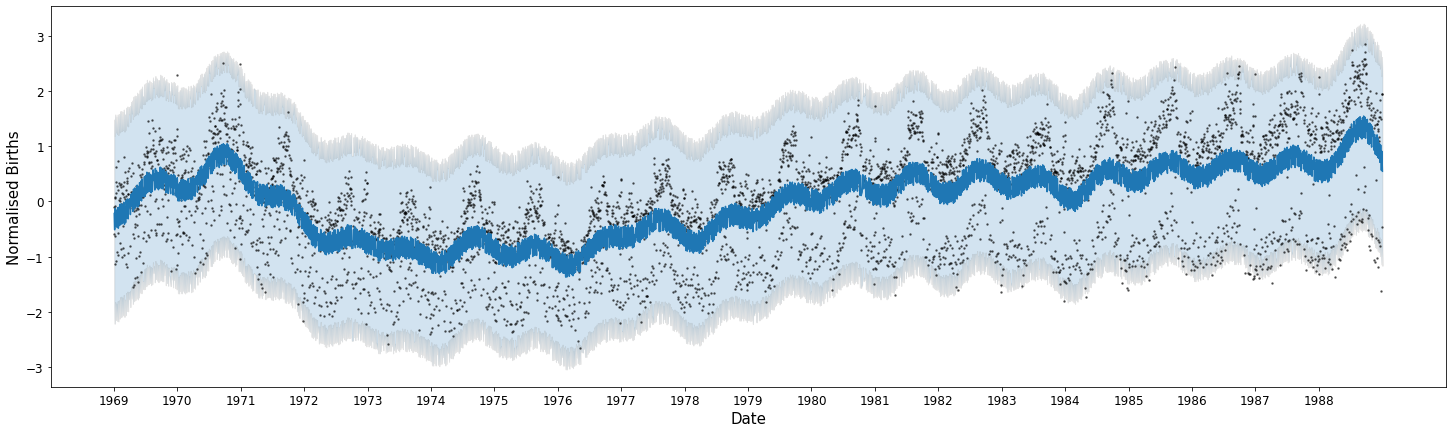

Test


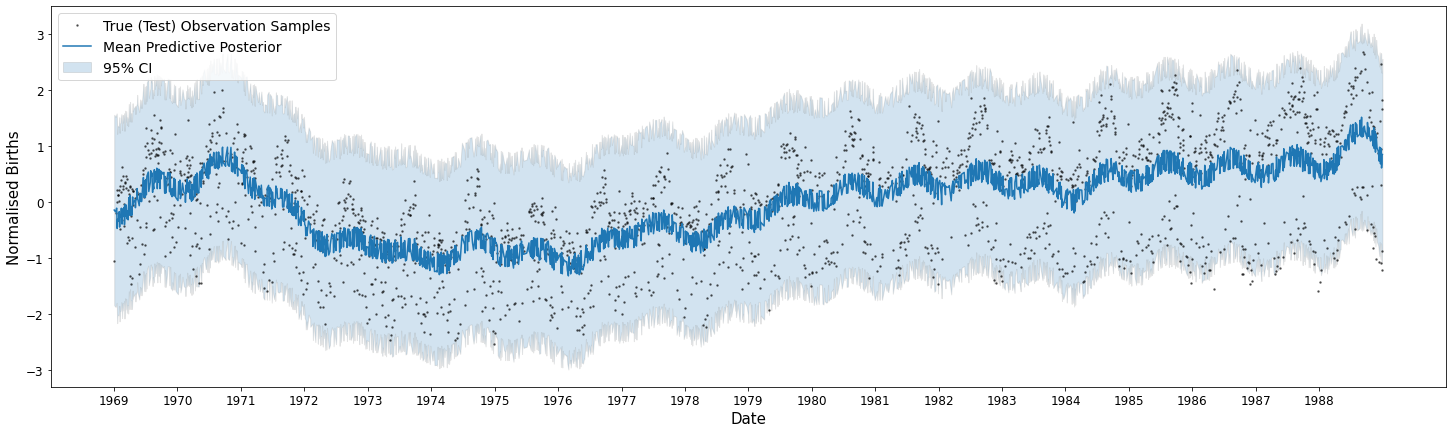

train ELBO, MSE, MAE:  -3475.8661153737025 0.46672786610291994 0.5552625154766374
test ELBO, MSE, MAE:  -3542.9634613474973 0.4982903957766952 0.5735663157588832
percentage out of CI (train, test):  0.8996675141795424 0.958029197080292
number out of CI (train, test):  46 21
Avg. CRPS (train, test):  0.3928930854164964 0.40495620933532966


--------------------------------------------------------
p, l1, l2, s1, s2:  365 77 0.5 1 1
--------------------------------------------------------
Train


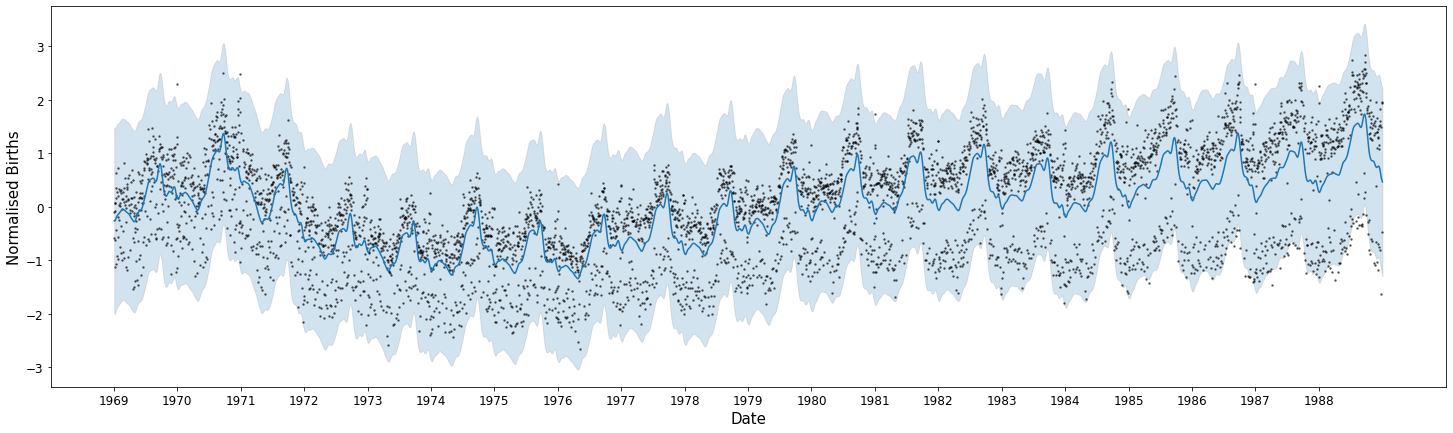

Test


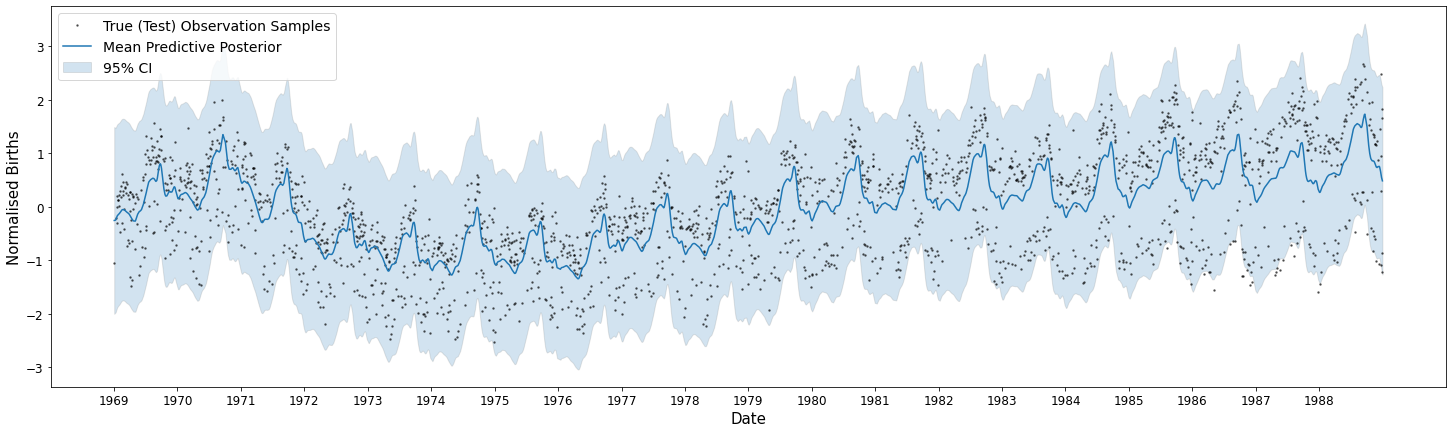

train ELBO, MSE, MAE:  -3575.484101289244 0.5410094521721714 0.6220522016572049
test ELBO, MSE, MAE:  -3641.932212082978 0.5723357366861085 0.6396788730084739
percentage out of CI (train, test):  1.1539213768824563 1.2773722627737227
number out of CI (train, test):  59 28
Avg. CRPS (train, test):  0.42280556339650965 0.434463141889726


--------------------------------------------------------
p, l1, l2, s1, s2:  365 77 1 1 1
--------------------------------------------------------
Train


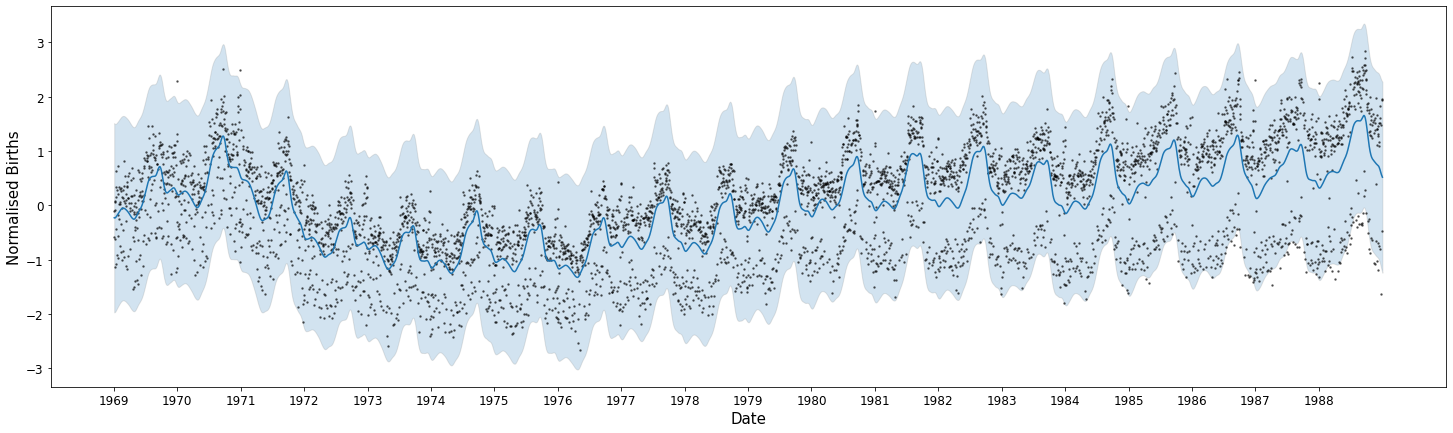

Test


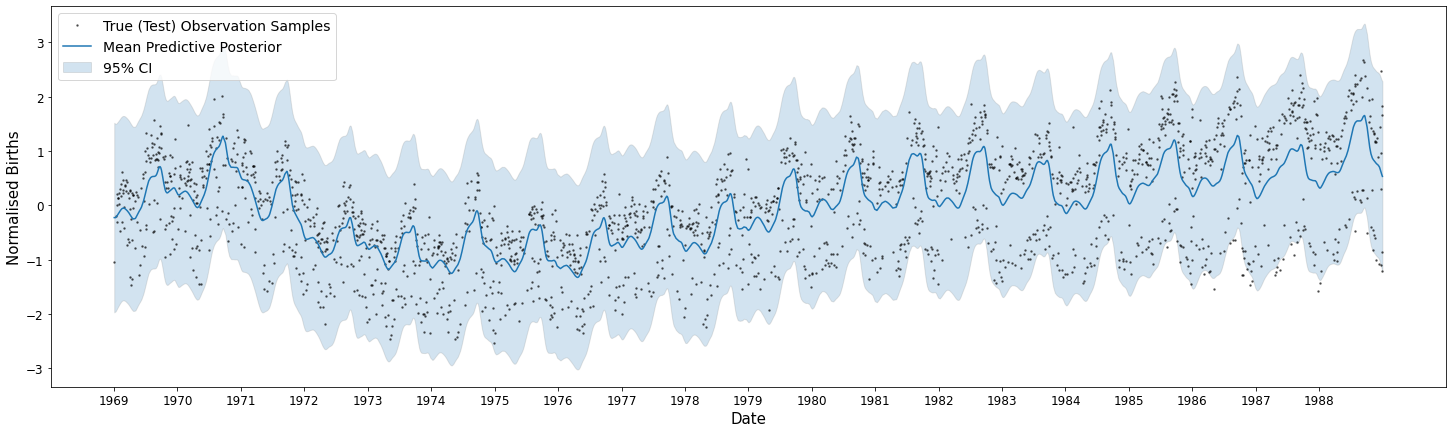

train ELBO, MSE, MAE:  -3573.71659586262 0.5445150284346901 0.6237097196181235
test ELBO, MSE, MAE:  -3637.420839201691 0.574611781145958 0.6402777356821088
percentage out of CI (train, test):  1.2125953451985134 1.2773722627737227
number out of CI (train, test):  62 28
Avg. CRPS (train, test):  0.4240625724332737 0.43521207614389806


--------------------------------------------------------
p, l1, l2, s1, s2:  365 100 0.5 1 1
--------------------------------------------------------
Train


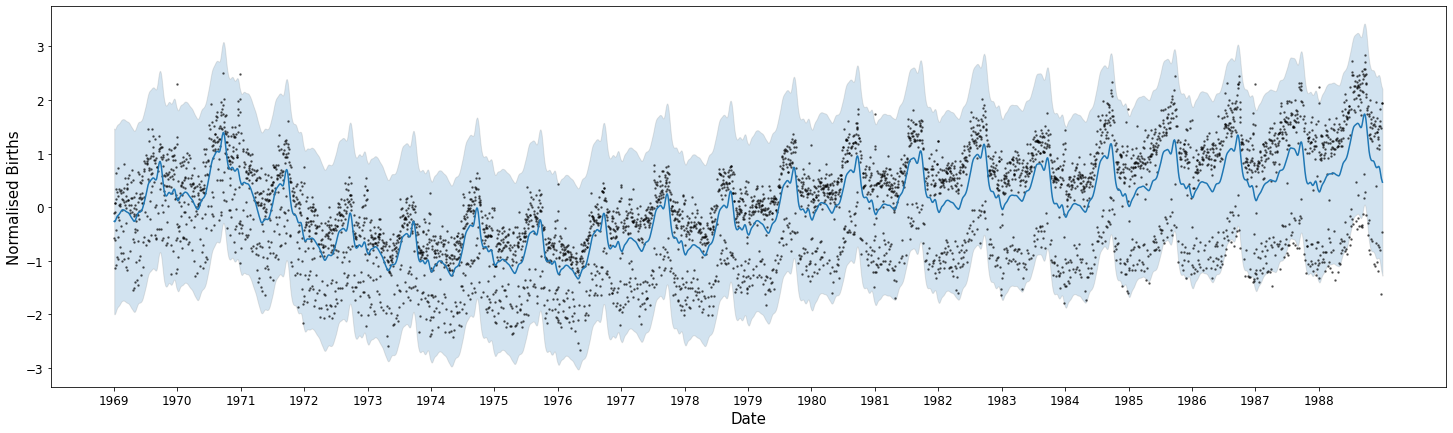

Test


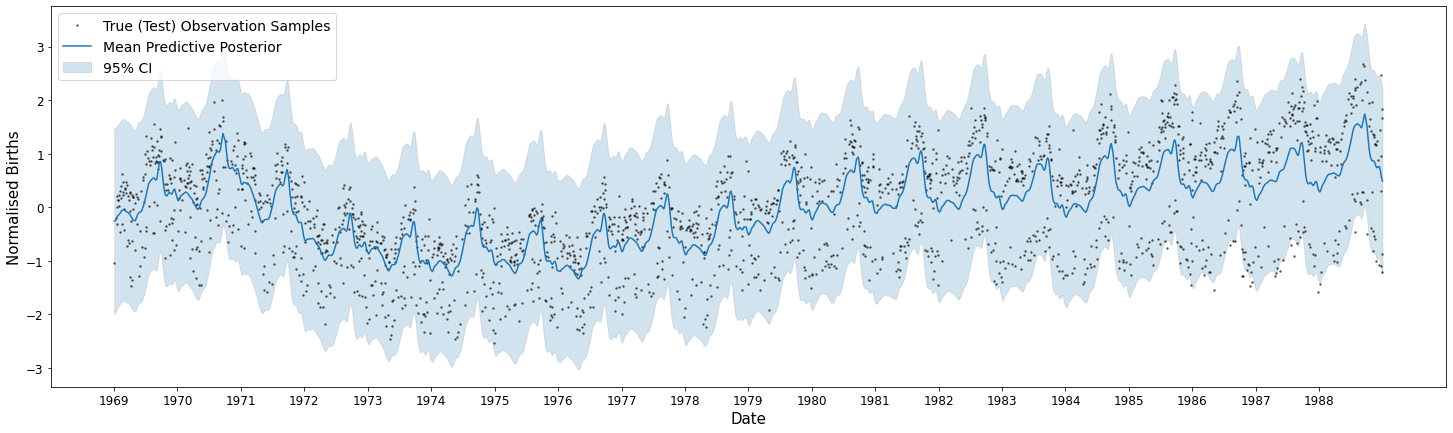

train ELBO, MSE, MAE:  -3554.6590302176155 0.5422293405080513 0.6227131346343195
test ELBO, MSE, MAE:  -3613.772565535315 0.5702197028245842 0.6383408534139484
percentage out of CI (train, test):  1.1734793663211422 1.1405109489051095
number out of CI (train, test):  60 25
Avg. CRPS (train, test):  0.4231795668995279 0.4336782595057227


--------------------------------------------------------
p, l1, l2, s1, s2:  365 100 1 1 1
--------------------------------------------------------
Train


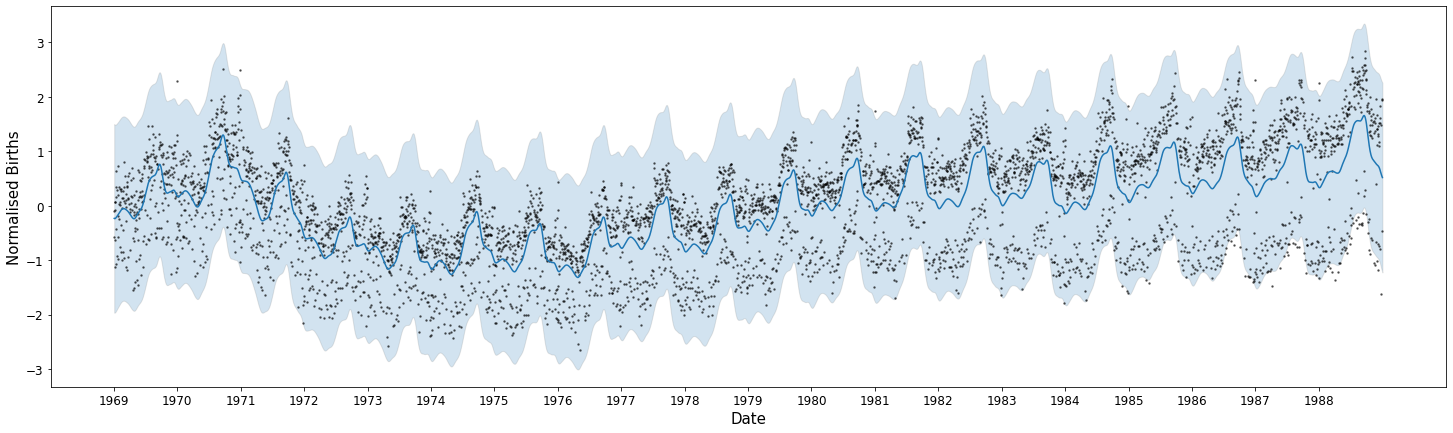

Test


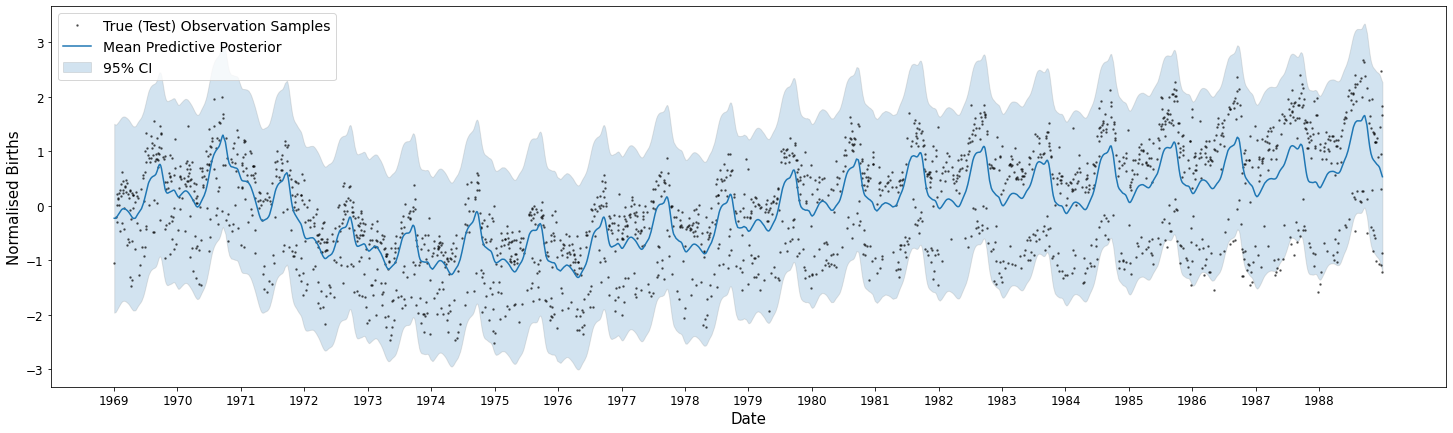

train ELBO, MSE, MAE:  -3552.80673584458 0.5457330378942103 0.624228347845728
test ELBO, MSE, MAE:  -3609.1247549849786 0.572457667531809 0.6387826029364541
percentage out of CI (train, test):  1.2908273029532564 1.2317518248175183
number out of CI (train, test):  66 27
Avg. CRPS (train, test):  0.4244180653180342 0.43438623339529947


--------------------------------------------------------
p, l1, l2, s1, s2:  365 150 0.5 1 1
--------------------------------------------------------
Train


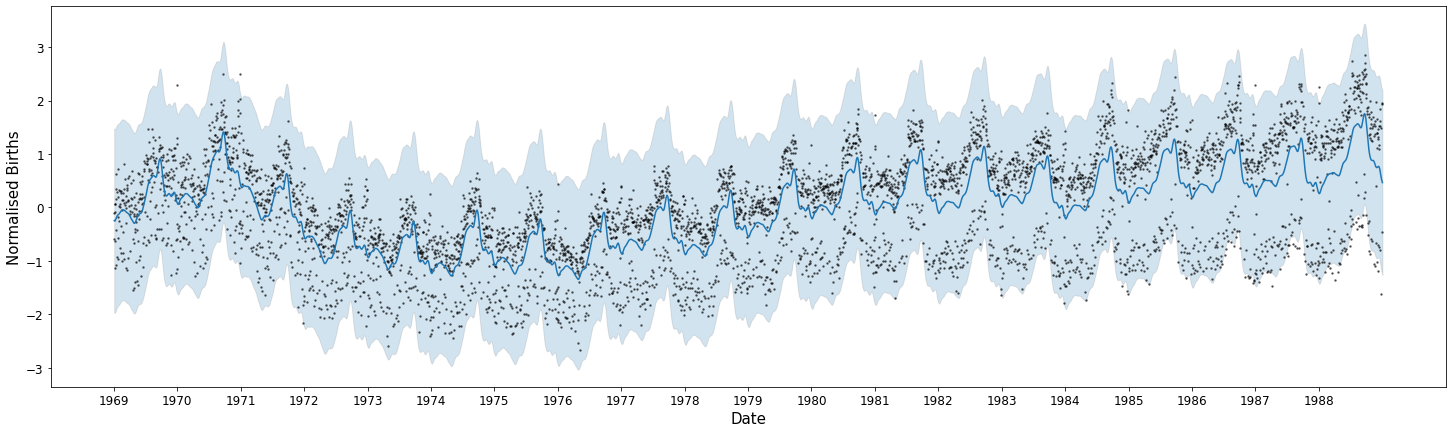

Test


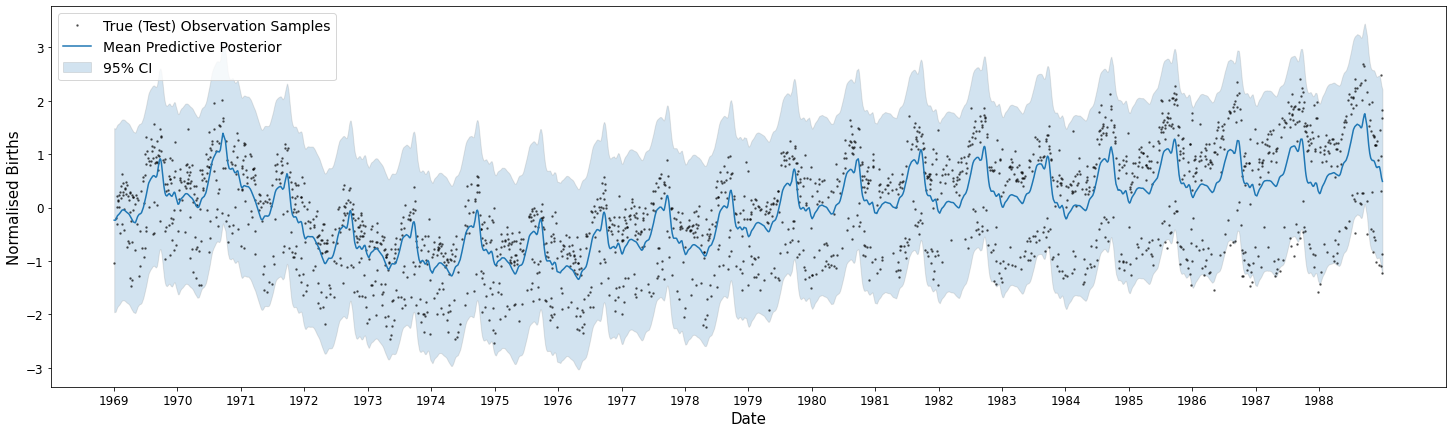

train ELBO, MSE, MAE:  -3530.3402748403255 0.5447050858061602 0.6237724425987388
test ELBO, MSE, MAE:  -3579.112677345492 0.5679201143402863 0.636652882576056
percentage out of CI (train, test):  1.3299432818306278 1.1861313868613137
number out of CI (train, test):  68 26
Avg. CRPS (train, test):  0.42394261246081205 0.43274406658695114


--------------------------------------------------------
p, l1, l2, s1, s2:  365 150 1 1 1
--------------------------------------------------------
Train


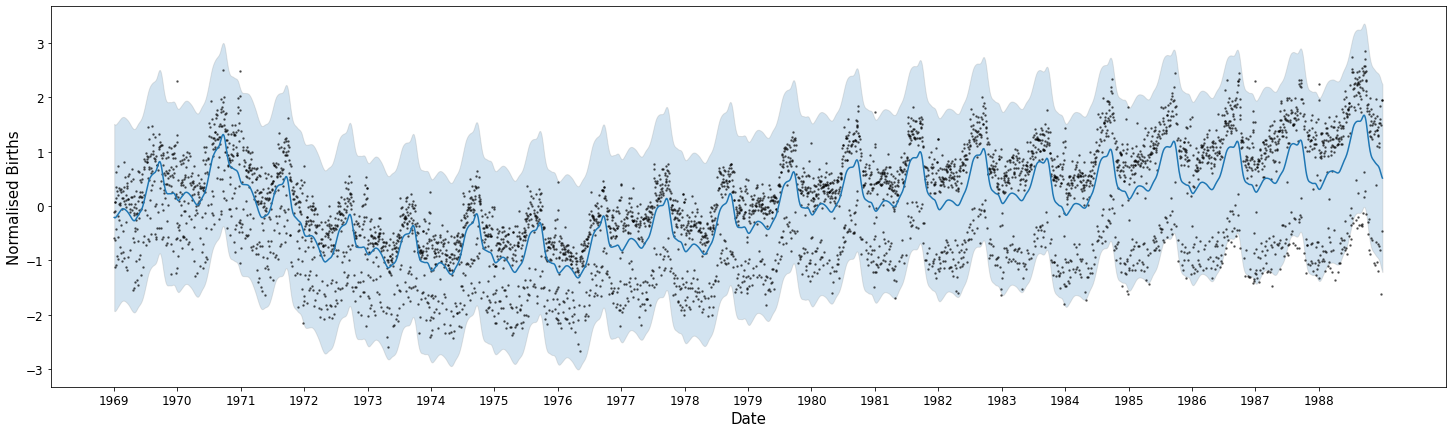

Test


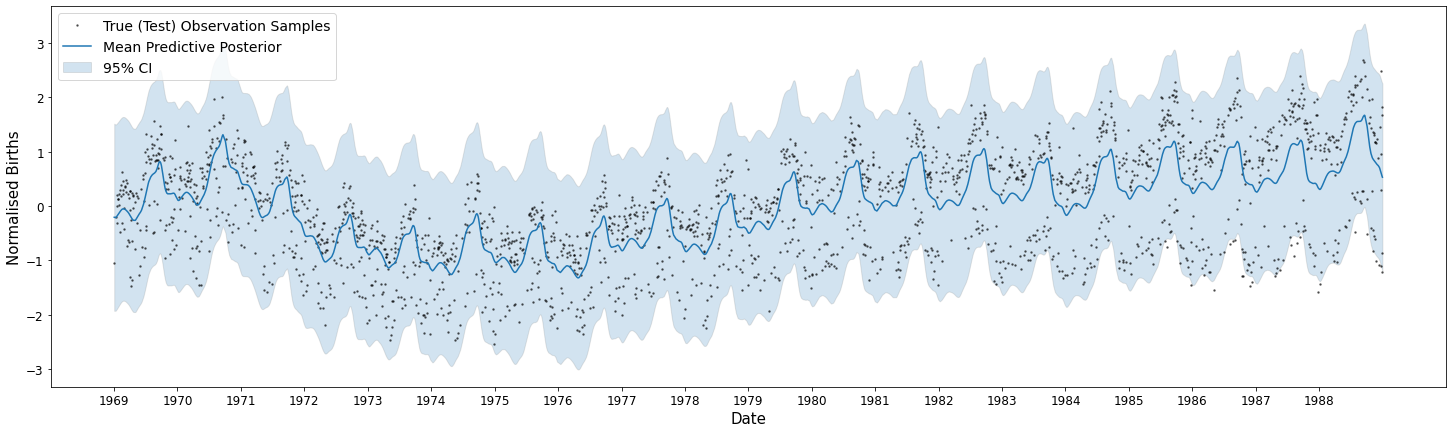

train ELBO, MSE, MAE:  -3528.386484367853 0.5482012796699437 0.6251534814465666
test ELBO, MSE, MAE:  -3574.2816485961293 0.5700934044517673 0.6370729164593286
percentage out of CI (train, test):  1.447291218462742 1.2317518248175183
number out of CI (train, test):  74 27
Avg. CRPS (train, test):  0.42515565184473636 0.43342130728488726


--------------------------------------------------------
p, l1, l2, s1, s2:  365 200 0.5 1 1
--------------------------------------------------------
Train


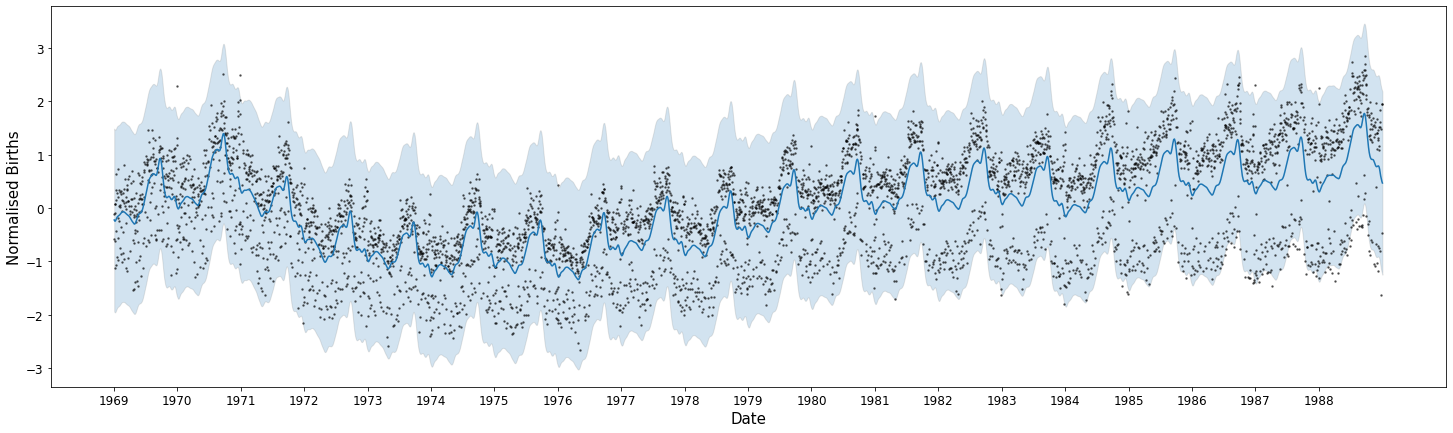

Test


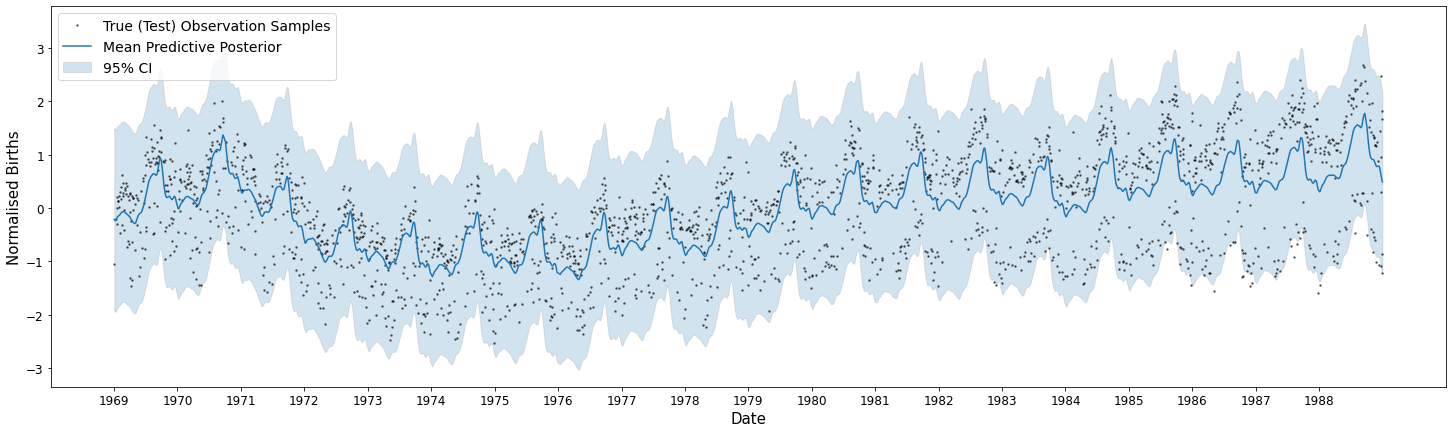

train ELBO, MSE, MAE:  -3520.6266800540534 0.5475655035388495 0.6245684155110713
test ELBO, MSE, MAE:  -3566.9107424906347 0.5696728636742531 0.6371772979979491
percentage out of CI (train, test):  1.3495012712693135 1.322992700729927
number out of CI (train, test):  69 29
Avg. CRPS (train, test):  0.42487620403927134 0.4332905657630311


--------------------------------------------------------
p, l1, l2, s1, s2:  365 200 1 1 1
--------------------------------------------------------
Train


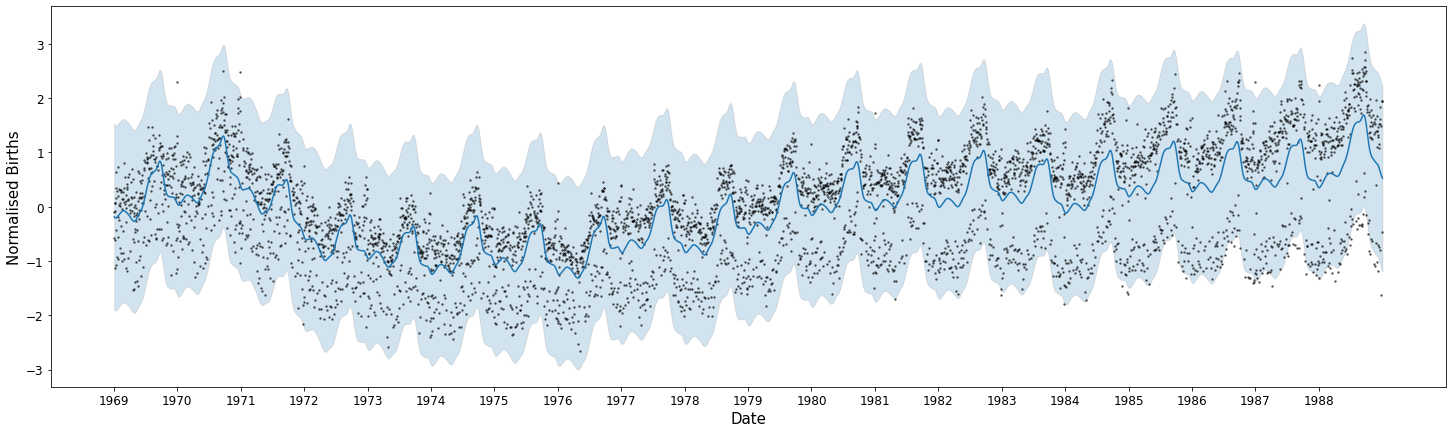

Test


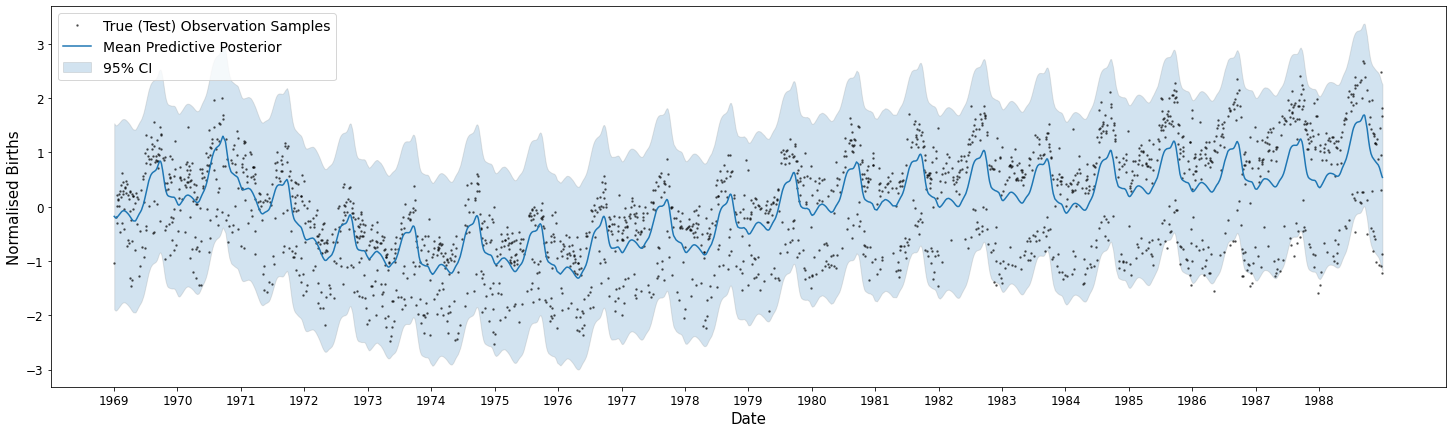

train ELBO, MSE, MAE:  -3518.5151234309724 0.5510793039146901 0.6258253898320176
test ELBO, MSE, MAE:  -3562.1804638213725 0.5719806825128207 0.6374853236852773
percentage out of CI (train, test):  1.3690592607079992 1.2317518248175183
number out of CI (train, test):  70 27
Avg. CRPS (train, test):  0.42609272522181474 0.4340409183137534


--------------------------------------------------------


: 

In [8]:
starting_values_p = [77, 365]
starting_values_l1 = [77, 170]
starting_values_l2 = [0.05, 1, 30]
starting_values_s1 = [0.5, 1]
starting_values_s2 = [0.1, 1]
s_noise = 0.5

M = 3000

curr_elbo = 0

for p in starting_values_p:
    for l1 in starting_values_l1:
        for l2 in starting_values_l2:
            for s1 in starting_values_s1:
                for s2 in starting_values_s2:
                    print('p, l1, l2, s1, s2: ', p, l1, l2, s1, s2)
                    print('--------------------------------------------------------')
                    kernel = gpflow.kernels.RBF(lengthscales=l1, variance=s1) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(lengthscales=l2, variance=s2), period=p)
                    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
                    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)

                    model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
                    model.likelihood.variance.assign(0.5)
                    model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
                    model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
                    model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
                    model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
                    model.kernel.kernels[1].period.prior = tfp.distributions.Uniform(to_default_float(0), to_default_float(1))

                    optimise_predict_model(model)
                    print('--------------------------------------------------------')